## Negative Sentiment Analysis - Topic Modeling

In [71]:
#df_analysis = pd.read_parquet('df_analysis.parquet', engine='pyarrow')
#- seperated from df_analysis into positive and negative
#df_positive = pd.read_parquet('df_positive.parquet', engine='pyarrow')
#df_negative = pd.read_parquet('df_negative.parquet', engine='pyarrow')
#lda_model_266 = topics on 37 topics of general corpus (it is 37 because i probably reduced it)
#lda_model_266 = topics on 37 topics of general corpus


In [2]:
import torch

print("CUDA is available:" , torch.cuda.is_available())
print("Number of CUDA devices:", torch.cuda.device_count())
print("CUDA version used by PyTorch:", torch.version.cuda)

for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i)) # prints the name of each available GPU

CUDA is available: True
Number of CUDA devices: 2
CUDA version used by PyTorch: 11.6
Tesla T4
Tesla T4


In [3]:
import numpy as np
import pandas as pd
# from gensim import corpora, models
# from gensim.models import Phrases
# from gensim.models import CoherenceModel
# from gensim.models.ldamodel import LdaModel
# from gensim.models.ldamulticore import LdaMulticore

#import pyLDAvis
#import pyLDAvis.gensim_models as gensimvis
from tqdm import tqdm

import re
import nltk
import os
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 600)

In [4]:
%%time

df_negative = pd.read_parquet('df_negative.parquet', engine='pyarrow')
df_negative.shape

CPU times: user 899 ms, sys: 588 ms, total: 1.49 s
Wall time: 2.78 s


(46684, 5)

# Entity Extraction from Negative Sentiment (200 sample only taken so far)

In [5]:
import spacy
from spacy import displacy

2023-05-25 18:07:35.074645: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 18:07:47.064349: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-25 18:07:47.068124: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-

In [6]:
# nlp = spacy.load("en_core_web_sm",exclude=['tok2vec','lemmatizer'])
nlp = spacy.load("en_core_web_lg",exclude=['tok2vec','lemmatizer'])


In [8]:
df_negative = pd.read_parquet('df_negative.parquet', engine='pyarrow')


In [7]:
spacy_content_df = pd.read_parquet('content_clean_spacy_final_project.parquet', engine='pyarrow')


In [8]:
#add spacy text (not lower cased and unclean) to the negative topics dataframe
df_negative = pd.merge(df_negative, spacy_content_df[["content_clean", "url"]], left_on="url", right_on="url", how="inner")
#df_topics_negative.drop("cleaned_text", axis=1, inplace=True)


In [9]:
df_negative.shape

(46013, 6)

# Trying new entity extraction parallel apply

In [34]:
df_analysis_sample = df_negative.sample(n=46013)  # Adjust the sample size as needed


In [36]:
df_analysis_sample['date'] = pd.to_datetime(df_analysis_sample['date'])


In [100]:
%%time
# Define the entity labels of interest
entity_labels = ['ORG', 'PRODUCT', 'PERSON']

# Function to extract entities by label from a single document
def extract_entities(row, label):
    doc = nlp(row['content_clean'])
    entities = [ent.text for ent in doc.ents if ent.label_ == label]
    return entities

# Add year column to dataframe for future use
df_analysis_sample['year'] = df_analysis_sample['date'].dt.year

# Dictionary to store top entities DataFrames by label
df_entities_by_label = {}

# Iterate over each entity label
for label in entity_labels:
    df_analysis_sample[label] = df_analysis_sample.parallel_apply(extract_entities, args=(label,), axis=1)

    # Generate a dataframe where rows correspond to entities, columns correspond to years, and cells contain counts
    entities_by_year = df_analysis_sample.groupby('year')[label].sum().apply(pd.Series.value_counts).unstack().fillna(0)
    
    # Sort the entities by their counts for each year and keep top N entities
    N = 30  # you can change this to keep as many top entities as you like
    top_entities_by_year = entities_by_year.apply(lambda x: x.nlargest(N) if isinstance(x, pd.Series) else x).unstack()

    df_entities_by_label[label] = top_entities_by_year


CPU times: user 5min 16s, sys: 15.3 s, total: 5min 32s
Wall time: 30min 22s


In [101]:
# Example: Accessing the top entities for 'ORG'
top_org_entities_neg = df_entities_by_label['ORG']
top_person_entities_neg = df_entities_by_label['PERSON']
top_product_entities_neg = df_entities_by_label['PRODUCT']


In [102]:
top_org_entities_neg.head(10)

year                        2020     2021     2022     2023
AI                       14090.0  16412.0  19308.0  36341.0
Google                   10062.0   7881.0  10624.0  30303.0
Facebook                  4294.0   5154.0   2979.0   5684.0
Microsoft                 3568.0   2881.0   2481.0  32082.0
Artificial Intelligence   2896.0   3153.0   1862.0   1966.0
Amazon                    2396.0   1998.0   1311.0   4007.0
IBM                       2217.0   2202.0    667.0   1090.0
Apple                     1988.0   1318.0   1632.0   4688.0
EU                        1618.0   2917.0   1414.0   2385.0
AP                        1295.0    742.0    887.0   4821.0

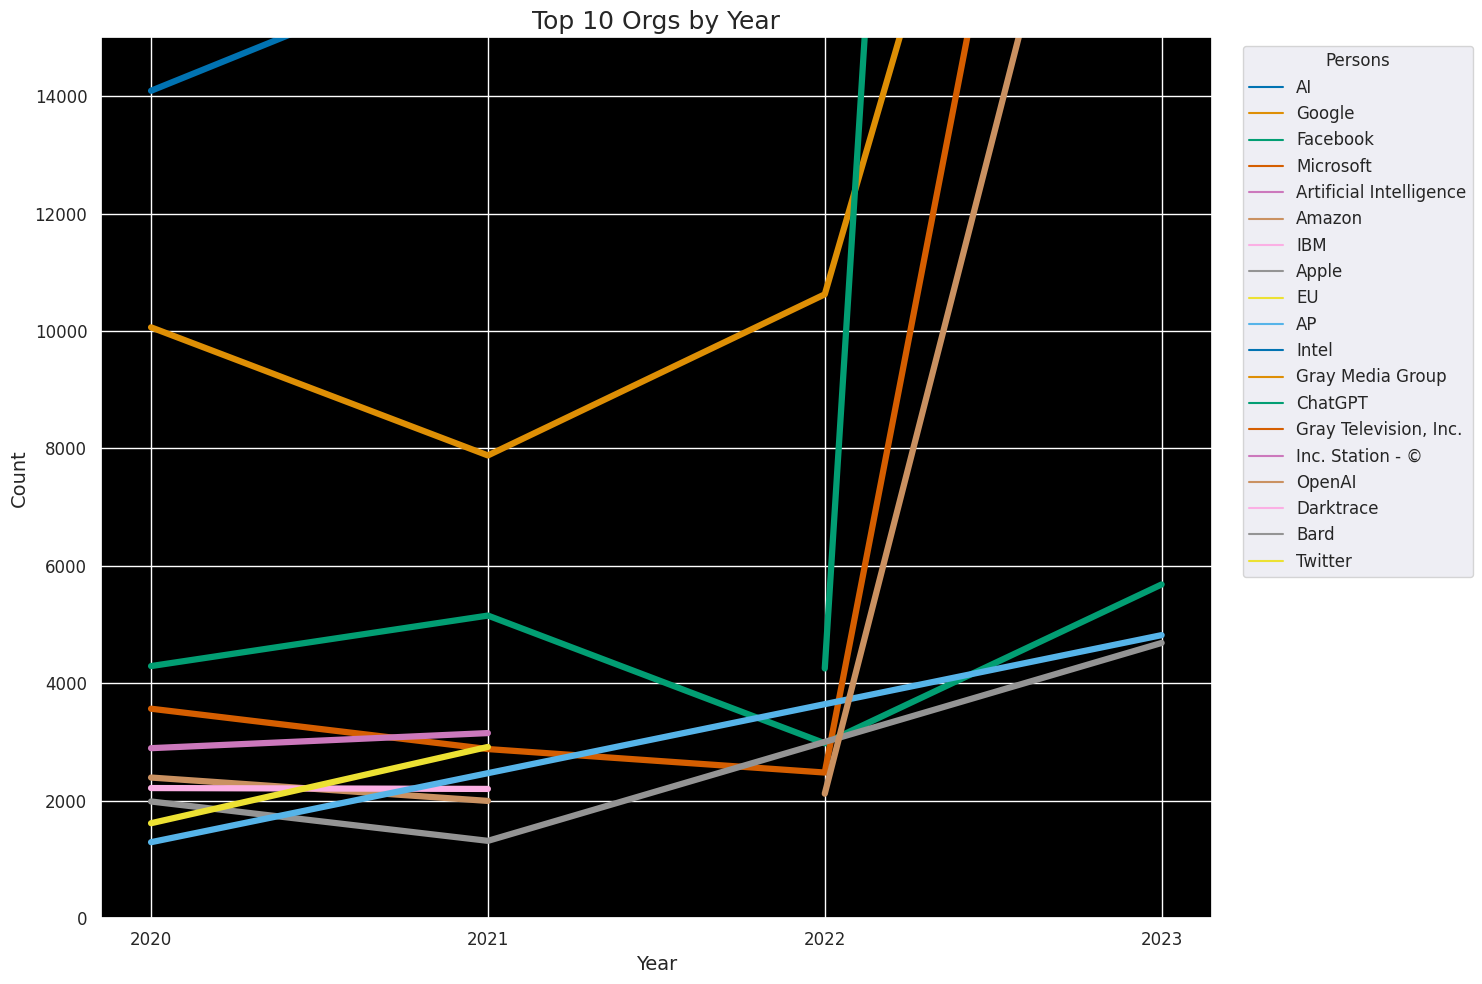

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Reset the index of the DataFrame so 'year' becomes a column
top_person_entities_neg_reset = top_org_entities_neg.reset_index()

# Rename the columns for clarification
top_person_entities_neg_reset = top_person_entities_neg_reset.rename(columns={'index': 'Entity'})

# Melt the DataFrame to make it suitable for plotting
df_melted = top_person_entities_neg_reset.melt(id_vars='Entity', var_name='Year', value_name='Count')

# Ensure 'Year' is integer for plotting
df_melted['Year'] = df_melted['Year'].astype(int)

# Select the top 10 entities for each year based on count
top_10_each_year = df_melted.groupby('Year').apply(lambda x: x.nlargest(10, 'Count')).reset_index(drop=True)

# Define a custom color palette for better differentiation of lines
custom_palette = sns.color_palette("colorblind", n_colors=len(top_10_each_year['Entity'].unique()))

# Create line plot with seaborn and custom palette
plt.figure(figsize=(15, 10))
sns.lineplot(data=top_10_each_year, x='Year', y='Count', hue='Entity', palette=custom_palette, linewidth=4.5)

# Set plot title and labels
plt.title('Top 10 Orgs by Year', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Persons', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Set y-axis limit
plt.ylim(0, 15000)

# Customize ticks and tick labels
plt.xticks([2020, 2021, 2022, 2023], fontsize=12)
plt.yticks(fontsize=12)

# Remove the right and top spines
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

# Adjust legend location
plt.legend(title='Persons', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)
# Set the style and context using Seaborn
sns.set_style("darkgrid")
sns.set_context("notebook")

# Set background color
plt.gca().set_facecolor('#000000')

plt.tight_layout()
plt.show()


In [98]:
top_person_entities_neg.head(5)

2020    2021    2022    2023
Trump      2086.0   797.0   599.0  4316.0
Gebru      1048.0   740.0    76.0    20.0
Biden       503.0  1643.0  1183.0  3489.0
Musk        464.0   346.0   841.0  5165.0
Elon Musk   452.0   457.0  1150.0  5105.0

In [103]:
top_org_entities_neg.columns = ['2020', '2021', '2022', '2023']
top_person_entities_neg.columns = ['2020', '2021', '2022', '2023']
top_product_entities_neg.columns = ['2020', '2021', '2022', '2023']


In [104]:
top_org_entities_neg.to_parquet('top_org_entities_neg.parquet', engine='pyarrow')
# top_person_entities_neg.to_parquet('top_person_entities_neg.parquet', engine='pyarrow')
# top_product_entities_neg.to_parquet('top_product_entities_neg.parquet', engine='pyarrow')

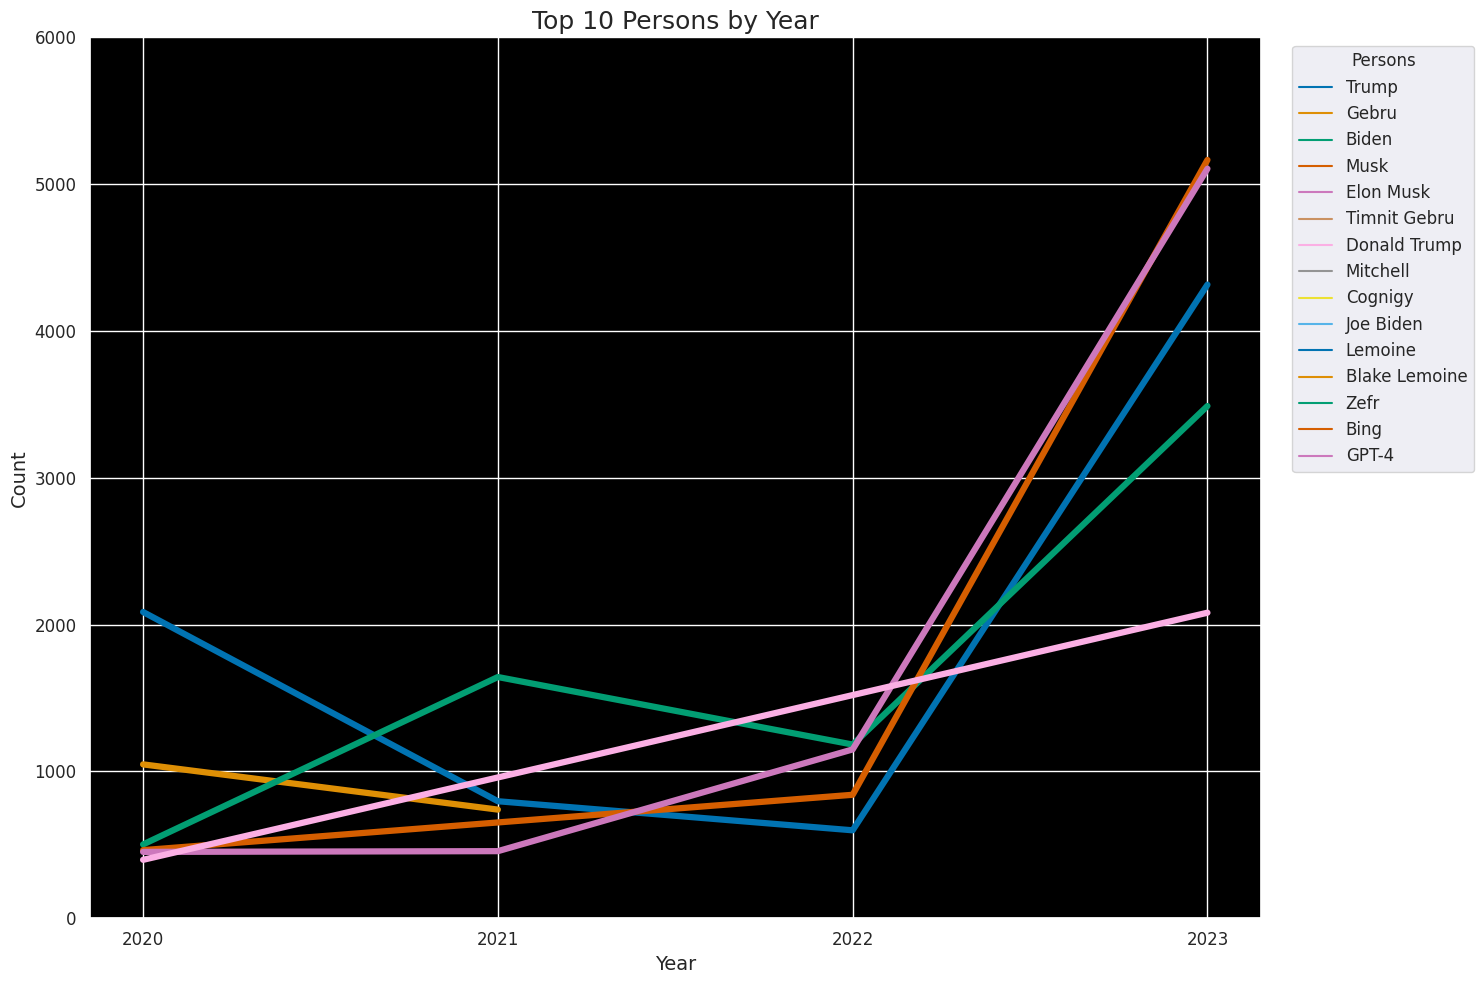

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Reset the index of the DataFrame so 'year' becomes a column
top_person_entities_neg_reset = top_person_entities_neg.reset_index()

# Rename the columns for clarification
top_person_entities_neg_reset = top_person_entities_neg_reset.rename(columns={'index': 'Entity'})

# Melt the DataFrame to make it suitable for plotting
df_melted = top_person_entities_neg_reset.melt(id_vars='Entity', var_name='Year', value_name='Count')

# Ensure 'Year' is integer for plotting
df_melted['Year'] = df_melted['Year'].astype(int)

# Select the top 10 entities for each year based on count
top_10_each_year = df_melted.groupby('Year').apply(lambda x: x.nlargest(7, 'Count')).reset_index(drop=True)

# Define a custom color palette for better differentiation of lines
custom_palette = sns.color_palette("colorblind", n_colors=len(top_10_each_year['Entity'].unique()))

# Create line plot with seaborn and custom palette
plt.figure(figsize=(15, 10))
sns.lineplot(data=top_10_each_year, x='Year', y='Count', hue='Entity', palette=custom_palette, linewidth=4.5)

# Set plot title and labels
plt.title('Top 10 Persons by Year', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Persons', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Set y-axis limit
plt.ylim(0, 6000)

# Customize ticks and tick labels
plt.xticks([2020, 2021, 2022, 2023], fontsize=12)
plt.yticks(fontsize=12)

# Remove the right and top spines
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

# Adjust legend location
plt.legend(title='Persons', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)
# Set the style and context using Seaborn
sns.set_style("darkgrid")
sns.set_context("notebook")

# Set background color
plt.gca().set_facecolor('#000000')

plt.tight_layout()
plt.show()


In [42]:
top_product_entities_neg.head(5)

year           2020     2021     2022     2023
AI          22321.0  26272.0  38058.0  78760.0
Facebook      280.0    292.0    263.0    731.0
YouTube       280.0    239.0    282.0    906.0
Galaxy        274.0     86.0     49.0    306.0
JavaScript    265.0    283.0    241.0    358.0

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choose the entity label to plot
label = 'ORG'  # replace this with the entity label you're interested in

# Retrieve the corresponding DataFrame of top entities by year
df = df_entities_by_label[label]

# Reset the index of the DataFrame for plotting. This will make the entity names a column of the DataFrame.
df.reset_index(inplace=True)

# Rename the index column to 'entity'
df.rename(columns={'index': 'entity'}, inplace=True)

# Melt the DataFrame to a long format suitable for plotting. The id_vars is now 'entity', and the column names (years) will become the 'year' variable.
df_melt = df.melt(id_vars='entity', var_name='year', value_name='count')

# Convert the 'year' column to int for better plotting
df_melt['year'] = df_melt['year']

# Plot the data
plt.figure(figsize=(15, 10))
sns.lineplot(data=df_melt, x='year', y='count', hue='entity')
plt.title('Top entities by year for label: {}'.format(label))
plt.show()


ValueError: Per-column arrays must each be 1-dimensional

In [5]:
#nltk.download('stopwords')

In [6]:
#!pip install gensim

In [7]:
#!pip install pyLDAvis

In [8]:
#!pip install nltk

In [9]:
#!pip install pyarrow    

In [10]:
#save this dataframe so i do not have to keep reading it in
#df_news_final_project.to_parquet('news_final_project.parquet', engine='pyarrow')
#where does it save?
#!ls

In [11]:
#!pip install pandarallel

In [17]:
import pandarallel
from pandarallel import pandarallel

In [18]:
import multiprocessing

num_processors = multiprocessing.cpu_count()

# Now you can use num_processors in your code.


In [19]:
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

INFO: Pandarallel will run on 31 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# BERT Topic modeling (on negative sentiment articles - 46k articles)

In [15]:
# bert topic on the sample above
#!pip install bertopic

In [7]:
from bertopic import BERTopic

pd.set_option('display.max_colwidth', 500)

2023-05-24 01:47:44.780908: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 01:47:46.965439: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-24 01:47:46.967385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-

In [14]:
docs = df_negative['cleaned_text'].tolist()


In [18]:
%%time

topic_model = BERTopic(language="english", min_topic_size=30, n_gram_range=(1,2), calculate_probabilities=False, verbose=True)
topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/1459 [00:00<?, ?it/s]

2023-05-19 21:07:26,957 - BERTopic - Transformed documents to Embeddings
2023-05-19 21:08:09,228 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-05-19 21:08:12,714 - BERTopic - Clustered reduced embeddings


CPU times: user 25min 2s, sys: 1min 44s, total: 26min 46s
Wall time: 7min 33s


In [19]:
freq = topic_model.get_topic_info()

print(f"Topics found: {freq.shape[0]}")
freq.head(20)
#xx topics found

Topics found: 324


Topic  Count  \
0      -1  15419   
1       0    734   
2       1    639   
3       2    590   
4       3    533   
5       4    526   
6       5    505   
7       6    473   
8       7    460   
9       8    441   
10      9    414   
11     10    375   
12     11    368   
13     12    354   
14     13    343   
15     14    335   
16     15    332   
17     16    302   
18     17    293   
19     18    280   

                                                                                                                                              Name  
0                                                                                                                                -1_ai_news_new_us  
1                                                                                                               0_students_chatgpt_school_teachers  
2                                                                                             1_market_analysis_artificial intelligence_artificial  
3                                                                                                                      2_musk_elon_elon musk_tesla  
4                                                                                                                3_ago_hours ago_hours_top stories  
5                                                                                                               4_covid_coronavirus_virus_patients  
6                                                                                                                  5_chatgpt_chatbot_google_openai  
7                                                                                                                        6_ct_language_gpt_chatgpt  
8                                                                                              7_venturebeat_follow_follow us_venturebeat homepage  
9                                                                                                                8_bard_google_google bard_chatbot  
10                                                                                                  9_paid program_paid_brandvoice_brandvoice paid  
11                                                                                                                 10_humans_human_ai_intelligence  
12                                                                                                                    11_npr_radio_schedule_donate  
13                                                                                                          12_ment_cision_overview_entertain ment  
14                                                                                                                       13_data_ai_business_cloud  
15                                                                                                                14_market_analysis_global_report  
16  15_days_may also_issuestrouble_violationsvandalismsocietysocietyenvironmentreligionadvocacyrelationshipscharitieskidsrelationship advicefamily  
17                                                                                                                            16_music_tpr_song_fm  
18                                                                                                                    17_art_artists_images_ai art  
19                                                                                                               18_product_product hunt_hunt_rank

In [20]:
topic_model.get_topic(0) 

[('students', 0.010687317713141862),
 ('chatgpt', 0.00788327687067913),
 ('school', 0.00527978435918385),
 ('teachers', 0.004948919463748753),
 ('student', 0.0048012964092225205),
 ('writing', 0.004579307486617502),
 ('education', 0.004174986374813471),
 ('schools', 0.00409992064428814),
 ('essay', 0.0037715609927290983),
 ('cheating', 0.003609892566091581)]

In [21]:
topic_model.get_topic(5) 

[('chatgpt', 0.010714661993161366),
 ('chatbot', 0.0037947208298784374),
 ('google', 0.0034323562692654065),
 ('openai', 0.0033636008110441065),
 ('language', 0.0030581518098921666),
 ('like', 0.002856319521367372),
 ('search', 0.0026099618408753286),
 ('human', 0.0025708863862203865),
 ('write', 0.0024594737863526013),
 ('gpt', 0.0023961919552191718)]

#### Visualize Topic Hierarchy

#### The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we can use scipy.cluster.hierarchy to create clusters and visualize how they relate to one another. This might help selecting an appropriate nr_topics when reducing the number of topics that you have created.

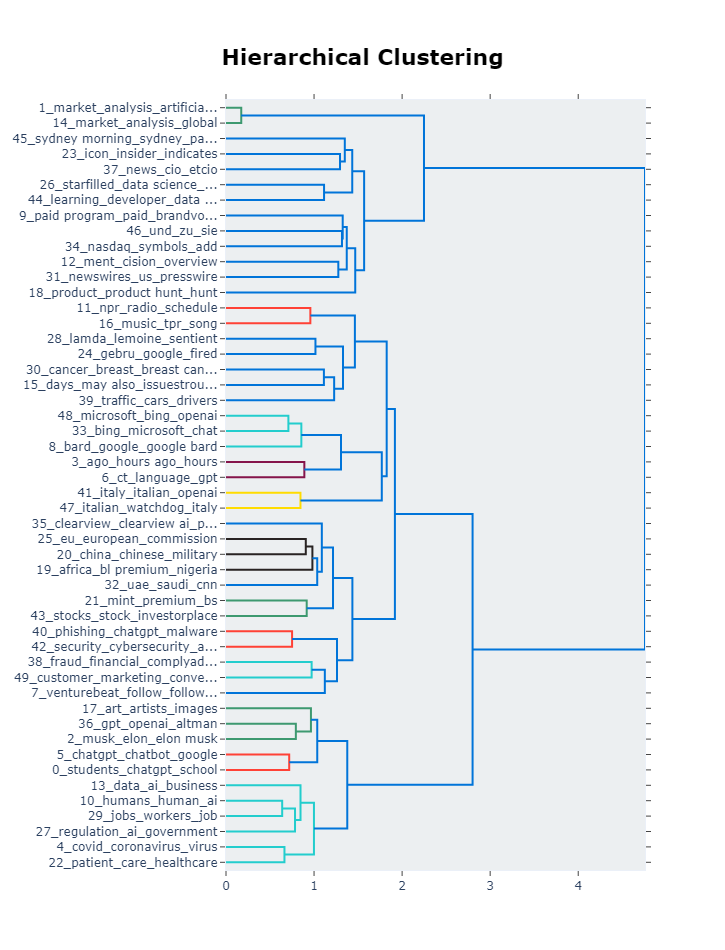

In [22]:
topic_model.visualize_hierarchy(top_n_topics=50)


In [23]:
#cant visualize topic probability distribution because probabilities not calculated for too many documents
# %%time
# # 
# topic_model.visualize_distribution(probs[100], min_probability=0.001)

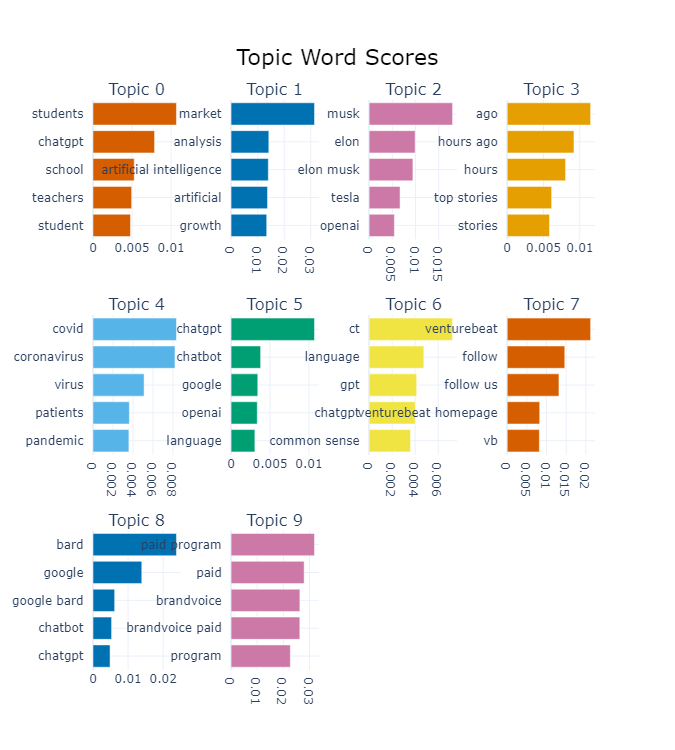

In [24]:
topic_model.visualize_barchart(top_n_topics=10)

In [8]:
path_lda = '/home/jupyter'


In [27]:
# Save model - 324 topics
topic_model.save(path_lda +'/lda_model_negative_324')

# Load model
#saved_model = BERTopic.load(path_lda +'/lda_model')

In [35]:
saved_model = BERTopic.load(path_lda +'/lda_model_negative_324')

#### topic reduction

In [28]:
%%time
new_topics = topic_model.reduce_topics(docs, nr_topics=200)
#topic_mod.reduce_topics(docs, nr_topics = 3) 


2023-05-19 21:34:06,358 - BERTopic - Reduced number of topics from 324 to 200


CPU times: user 3min 59s, sys: 5.56 s, total: 4min 5s
Wall time: 3min 59s


In [29]:
freq = new_topics.get_topic_info()

print(f"Topics found: {freq.shape[0]}")
freq.head(20)
#xx topics found

Topics found: 200


Topic  Count                                                  Name
0      -1  15419                                     -1_ai_news_new_us
1       0   1652                       0_market_analysis_global_report
2       1   1329                         1_chatgpt_openai_gpt_language
3       2    971                          2_bing_microsoft_bard_google
4       3    784                     3_students_chatgpt_writing_school
5       4    758                     4_ago_hours ago_hours_top stories
6       5    621                     5_stocks_stock_investment_trading
7       6    608                          6_google_gebru_lamda_lemoine
8       7    606                     7_health_medical_patient_patients
9       8    597                             8_schedule_npr_radio_wfmz
10      9    590                           9_musk_elon_elon musk_tesla
11     10    583            10_security_cyber_darktrace_cyber security
12     11    544                       11_ai_human_humans_intelligence
13     12    538       12_paid program_paid_brandvoice_brandvoice paid
14     13    526                     13_covid_coronavirus_virus_health
15     14    499                         14_images_higgins_image_trump
16     15    474                           15_china_chinese_beijing_us
17     16    460  16_venturebeat_follow_follow us_venturebeat homepage
18     17    396                         17_mint_share_premium_chatgpt
19     18    377                       18_africa_bl premium_nigeria_bl

In [30]:
new_topics.get_topic(0)

[('market', 0.02908676125354408),
 ('analysis', 0.012906196079722694),
 ('global', 0.011585196166690489),
 ('report', 0.011469206613984956),
 ('growth', 0.011046580561784189),
 ('artificial intelligence', 0.010844246205423774),
 ('artificial', 0.010716872417012307),
 ('intelligence', 0.010650100770378045),
 ('players', 0.00818906545431726),
 ('key', 0.008179032817210568)]

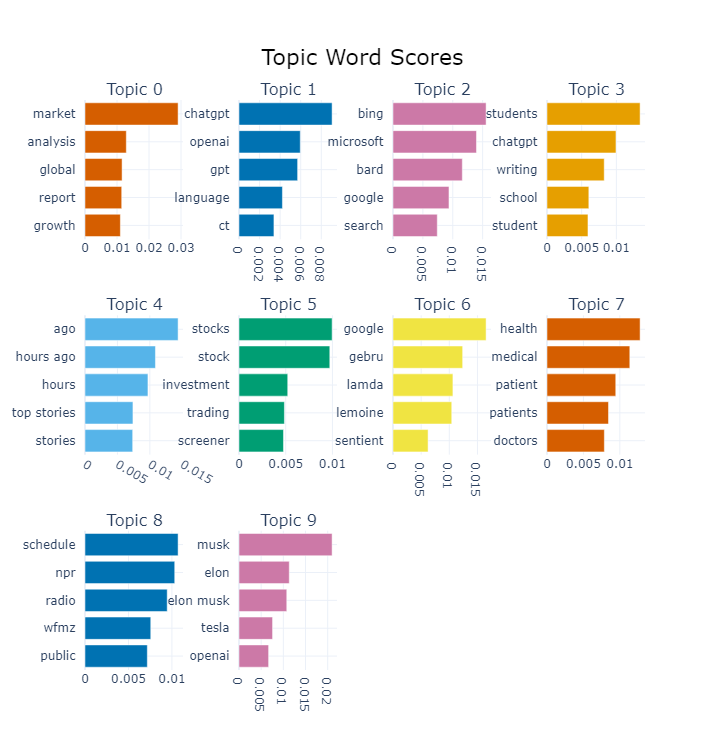

In [31]:
new_topics.visualize_barchart(top_n_topics=10)

CPU times: user 5min 31s, sys: 25.9 s, total: 5min 57s
Wall time: 5min 56s


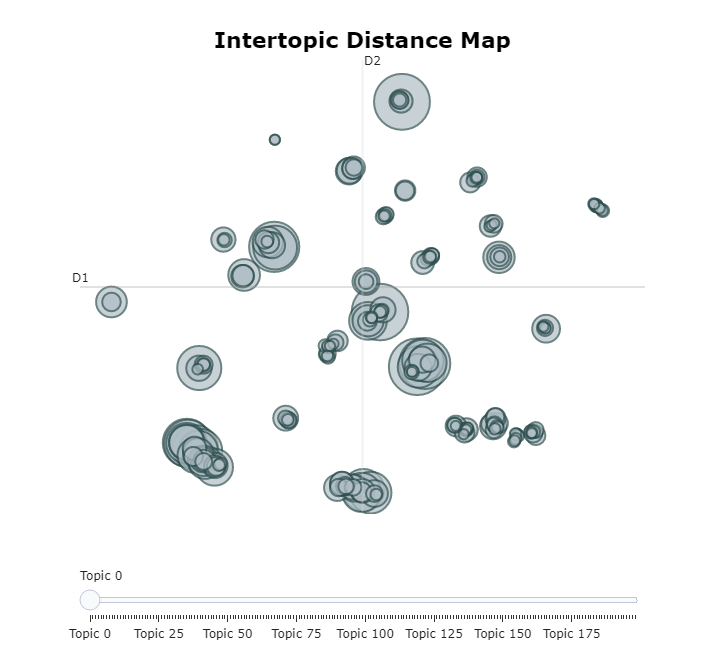

In [20]:
%%time

new_topics.visualize_topics()
#

# Decided on 60 topics by counting 60 clusters from the vizualization above


#### reduction to 27 topics

In [28]:
df_negative.shape

(46684, 5)

In [36]:
%%time
new_topics_negative_50 = saved_model.reduce_topics(docs, nr_topics=60)
#topic_mod.reduce_topics(docs, nr_topics = 3) 


CPU times: user 3min 41s, sys: 4.21 s, total: 3min 45s
Wall time: 3min 42s


In [89]:
freq = saved_model.get_topic_info()

print(f"Topics found: {freq.shape[0]}")
freq.head(60)
#xx topics found
#which topics interest me?
#topic 2 (chatgpt/students), topic 3 (china), topic 4 (health / medical), topic 5 (cybersecurity), 
#topic 6 (clearview, haeleon, human intelligence)
#topic 7 (elon musk ai) 
#topic 9 (ford driving automotive ai)
#topic 10 (eu rules ai)
#topic 14 (soundhound whisper ai)
#topic 16 (climate change)
#topic 18 (airlines)
#topic 20 (insurance)
#topic 23 (patent inventor drug law)
#topic 27 (agriculture ai)
#topic 40 (biometrics)
#topic 41 (oil gas)
#topic 43 bill gates
#topic 46 iot intelligence
#topic 25 (shipping vessels - forced labor)

Topics found: 60


Topic  Count                                                       Name
0      -1  15419                                          -1_ai_news_new_us
1       0  10049                                           0_news_ai_us_new
2       1   5610                                      1_market_ai_best_data
3       2   2761                                      2_ai_new_said_chatgpt
4       3   1810                                      3_china_news_ai_world
5       4   1596                             4_health_medical_patients_news
6       5   1041                              5_security_cyber_ai_darktrace
7       6    902                                6_ai_haleon_clearview_human
8       7    685                                   7_musk_elon_elon musk_ai
9       8    652                               8_news_colorado_weather_said
10      9    489                                     9_ford_driving_ai_cars
11     10    469                                    10_eu_ai_european_rules
12     11    460                         11_venturebeat_follow_follow us_ai
13     12    419                          12_icon_arrow right_arrow_insider
14     13    289                       13_soundhound_soundhound ai_voice_ai
15     14    246                       14_opens new_opens_new window_window
16     15    240                                  15_lunit_qynapse_ai_qwiet
17     16    221                       16_climate_climate change_change_bcg
18     17    208                                17_fuel_airlines_mbzuai_ibm
19     18    207                  18_hashtag_hashtag trending_itwc_trending
20     19    202                              19_eyeart_diabetic_retina_eye
21     20    195                         20_insurance_zefr_fairplay_adverif
22     21    194                  21_sydney_sydney morning_party ad_morning
23     22    171                         22_republic_kingdom_email_password
24     23    163                                23_patent_inventor_drug_law
25     24    155                24_nvidia_review_recent additions_additions
26     25    140                  25_shipping_vessels_maritime_forced labor
27     26    110                            26_sermon_sermons_franklin_pope
28     27     85    27_agriculture_agriculture market_market_ai agriculture
29     28     84           28_toggle dropdown_dropdown_toggle_straits times
30     29     78                 29_skin_age disrupting_skincare_disrupting
31     30     75               30_lianlian_lianlian global_global_ecommerce
32     31     72               31_canvass_canvass ai_industrial_cb insights
33     32     72                           32_impakt_virtual_events_informa
34     33     64                            33_food_market_waste_food waste
35     34     61                                  34_dog_animals_animal_vet
36     35     59                 35_tolerance_tolerance ca_ca_victor teboul
37     36     53                    36_semitism_anti semitism_anti_implicit
38     37     49                       37_ivf_ai academy_academy_fairtility
39     38     49                        38_primer_yonder_disinformation_nlp
40     39     48                     39_protein_proteins_deepmind_alphafold
41     40     47                     40_biometrics_biometric_recognition_id
42     41     46                        41_oil gas_oil_gas_intelligence oil
43     42     45                  42_earthquake_tsunami_earthquakes_seismic
44     43     44                                43_gates_bill gates_bill_ai
45     44     44                    44_bioethics_views posted_posted_ethics
46     45     43                      45_parking_fine_parking ticket_notice
47     46     42                  46_iot_intelligence iot_market_iot market
48     47     40  47_exports_analyzing satellite_satellite_satellite images
49     48     39                 48_smartcare_select data_select_post acute
50     49     39                    49_sciencelogic_zebrium_root cause_root
51     50     35                                   5

In [83]:
topic_model.get_topic(0)

[('news', 0.007405252543827842),
 ('ai', 0.006092027846908927),
 ('us', 0.0057810019052370164),
 ('new', 0.0056724081659317105),
 ('chatgpt', 0.005374548836430041),
 ('ago', 0.004972084758483603),
 ('google', 0.004693466862616686),
 ('said', 0.004332600604626917),
 ('search', 0.004179541590090548),
 ('technology', 0.00370243116406432)]

In [84]:
topic_model.get_topic(1)

[('market', 0.017221707394202333),
 ('ai', 0.009082598465034522),
 ('best', 0.009024070405494381),
 ('data', 0.008318310469694291),
 ('intelligence', 0.007828308756953088),
 ('artificial', 0.007441900313400519),
 ('artificial intelligence', 0.0074050821106429205),
 ('global', 0.006650609096339071),
 ('analysis', 0.006522860125863412),
 ('report', 0.006220708283179296)]

In [85]:
topic_model.get_topic(2)

[('ai', 0.008819494443238856),
 ('new', 0.0055501189202276984),
 ('said', 0.005522715015329383),
 ('chatgpt', 0.005336119976508489),
 ('students', 0.0053012652306209905),
 ('news', 0.005264595651365262),
 ('use', 0.005091125686074336),
 ('technology', 0.005020586521212914),
 ('rights', 0.004315063316597028),
 ('us', 0.004036904112252999)]

In [86]:
topic_model.get_topic(3)

[('china', 0.007562316080931663),
 ('news', 0.007174628153333819),
 ('ai', 0.006502221736585907),
 ('world', 0.006089358346871854),
 ('us', 0.005520043142706753),
 ('said', 0.004678549538788894),
 ('africa', 0.004590238526296292),
 ('technology', 0.004411636814258733),
 ('business', 0.004331079604250628),
 ('new', 0.004252086956044395)]

In [137]:
topic_model.get_topic(51)

[('edt', 0.11181561684224088),
 ('pm', 0.11001760482621853),
 ('est', 0.09340991815208681),
 ('pm edt', 0.07947858509232669),
 ('pm est', 0.07197361023204527),
 ('mar', 0.03136966677289483),
 ('jan', 0.030996411858508773),
 ('jan pm', 0.027564418450770324),
 ('mar pm', 0.025101145676307435),
 ('may pm', 0.02489490483529554)]

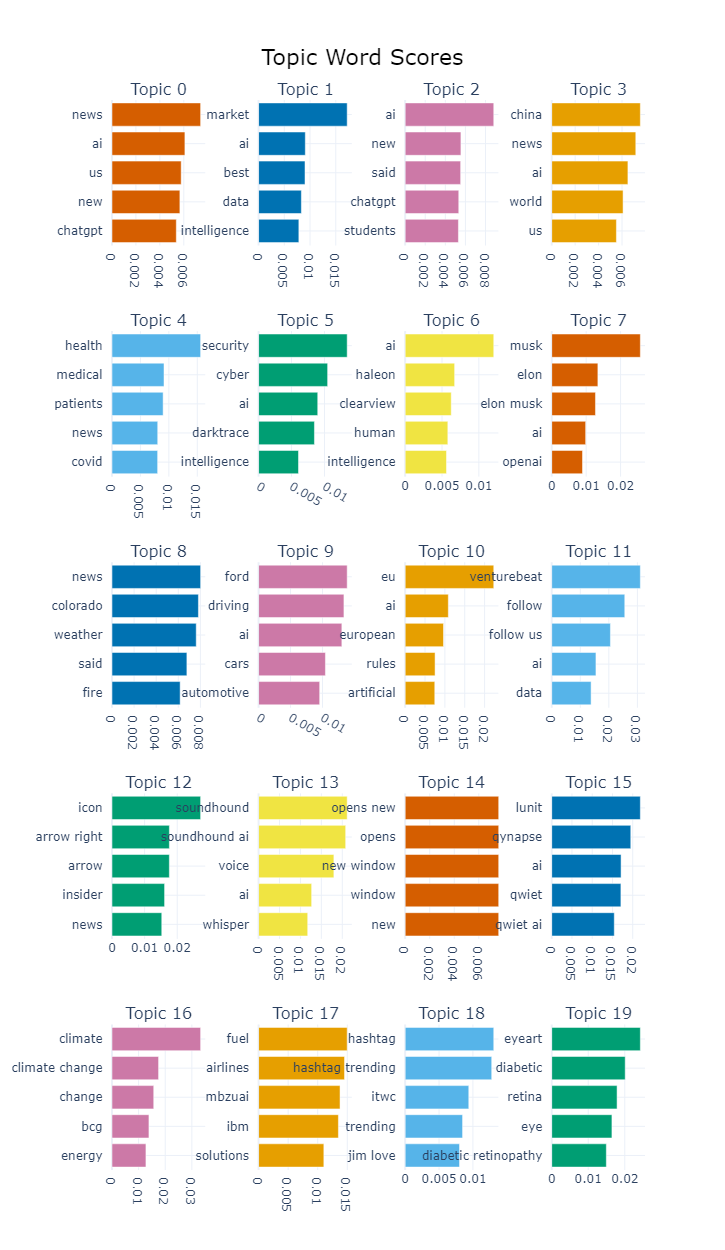

In [90]:
topic_model.visualize_barchart(top_n_topics=20)

#### topic reduction (removal of outliers)

In [40]:
topic_model = new_topics_negative_50

In [41]:
topic_frequencies = pd.DataFrame(topic_model.get_topic_info())


In [42]:
topic_frequencies.shape

(60, 3)

In [43]:
topic_frequencies.head(5)

Topic  Count                   Name
0     -1  15419      -1_ai_news_new_us
1      0  10049       0_news_ai_us_new
2      1   5610  1_market_ai_best_data
3      2   2761  2_ai_new_said_chatgpt
4      3   1810  3_china_news_ai_world

In [44]:
# Remove the topic with a topic value of -1
topic_frequencies = topic_frequencies[topic_frequencies['Topic'] != -1]

# Get the count of remaining articles in the topics
remaining_articles = topic_frequencies.shape[0]

# Print the number of remaining articles
print("Number of topics after removing the topic with value -1:", remaining_articles)

# Calculate the sum of the "Count" column
remaining_articles = topic_frequencies['Count'].sum()

# Print the number of remaining articles
print("Number of remaining articles in the topics:", remaining_articles)


Number of topics after removing the topic with value -1: 59
Number of remaining articles in the topics: 31265


In [45]:
topic_frequencies.head()

Topic  Count                            Name
1      0  10049                0_news_ai_us_new
2      1   5610           1_market_ai_best_data
3      2   2761           2_ai_new_said_chatgpt
4      3   1810           3_china_news_ai_world
5      4   1596  4_health_medical_patients_news

In [65]:
#leverage this below is key for this topic search 
#topic_model.get_document_info(docs)


In [63]:
#get representative docs per topic 
#topic_model.get_representative_docs(1)


In [46]:
df_topics_negative = topic_model.get_document_info(docs)


In [47]:
#removing outliers
df_topics_negative = df_topics_negative[df_topics_negative['Topic'] != -1]


In [62]:
#add date to the negative topics dataframe
df_topics_negative = pd.merge(df_topics_negative, df_negative[["cleaned_text", "date"]], left_on="Document", right_on="cleaned_text", how="inner")
df_topics_negative.drop("cleaned_text", axis=1, inplace=True)


In [102]:
#add url to the negative topics dataframe

df_topics_negative = pd.merge(df_topics_negative, df_negative[["cleaned_text", "url"]], left_on="Document", right_on="cleaned_text", how="inner")
df_topics_negative.drop("cleaned_text", axis=1, inplace=True)


In [107]:
#add spacy text (not lower cased and unclean) to the negative topics dataframe
df_topics_negative = pd.merge(df_topics_negative, spacy_content_df[["content_clean", "url"]], left_on="url", right_on="url", how="inner")
#df_topics_negative.drop("cleaned_text", axis=1, inplace=True)


In [112]:
#add title (cleaned) to the negative topics dataframe
df_topics_negative = pd.merge(df_topics_negative, df_negative[["clean_title", "cleaned_text"]], left_on="Document", right_on="cleaned_text", how="inner")
df_topics_negative.drop("cleaned_text", axis=1, inplace=True)


In [120]:
#add spacy title (not lower cased and unclean) to the negative topics dataframe
df_topics_negative = pd.merge(df_topics_negative, spacy_content_df[["title", "url"]], left_on="url", right_on="url", how="inner")
#df_topics_negative.drop("cleaned_text", axis=1, inplace=True)


In [121]:
df_topics_negative.shape
#the merges must have messed up a little bit - shape is different from before adding all the columns

(36234, 11)

In [123]:
# spacy_content_df = pd.read_parquet('content_clean_spacy_final_project.parquet', engine='pyarrow')
# spacy_content_df.head(1)

#### Looking at representative documents

In [124]:
df_topics_negative["Representative_document"].value_counts()
#after removing -1 (outliers)

False    35996
True       238
Name: Representative_document, dtype: int64

In [125]:
filtered_df = df_topics_negative[df_topics_negative["Representative_document"] == True]
filtered_df.shape

(238, 11)

In [199]:
#filtered_df.head(1)

In [128]:
#PARQUET SAVE
df_topics_negative.to_parquet('df_topics_negative_60.parquet', engine='pyarrow')

# Checkpoint: Read Parquet File

In [ ]:
df_topics_negative = pd.read_parquet('df_topics_negative_60.parquet', engine='pyarrow')
#df_negative = pd.read_parquet('df_negative.parquet', engine='pyarrow')


# Sentiment Analysis on targetted topics within the 60 negative topics 

#### topic search - Chat GPT

In [129]:
similar_topics, similarity = topic_model.find_topics("chat gpt", top_n=5); similar_topics

[2, 45, 0, 51, 15]

In [130]:
similar_topics, similarity = topic_model.find_topics("chatgpt", top_n=5); similar_topics

[0, 2, 45, 15, -1]

In [131]:
similar_topics, similarity = topic_model.find_topics("gpt", top_n=5); similar_topics

[15, 51, 45, 2, 18]

#### the above suggest that ChatGPT is most represented by topic 2 in negative topics

#### lets take a look at the number of articles over time in 2 topic 2 as a result

In [ ]:
selected_topics = [2]
chatgpt_df = df_topics_negative[df_topics_negative['Topic'].isin(selected_topics)]


In [143]:
chatgpt_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3209 entries, 2 to 36233
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Document                 3209 non-null   object 
 1   Topic                    3209 non-null   int64  
 2   Name                     3209 non-null   object 
 3   Top_n_words              3209 non-null   object 
 4   Probability              3209 non-null   float64
 5   Representative_document  3209 non-null   bool   
 6   date                     3209 non-null   object 
 7   url                      3209 non-null   object 
 8   content_clean            3209 non-null   object 
 9   clean_title_x            3209 non-null   object 
 10  title                    3209 non-null   object 
dtypes: bool(1), float64(1), int64(1), object(8)
memory usage: 278.9+ KB


In [ ]:
chatgpt_df

In [ ]:
chatgpt_filtered = chatgpt_df[chatgpt_df['Probability'] > 0.99]

# Count the number of rows satisfying the condition
count = chatgpt_filtered.shape[0]
count

#1326 topics chosen from 3209 to plot as most representative according to probability method of Bertopics

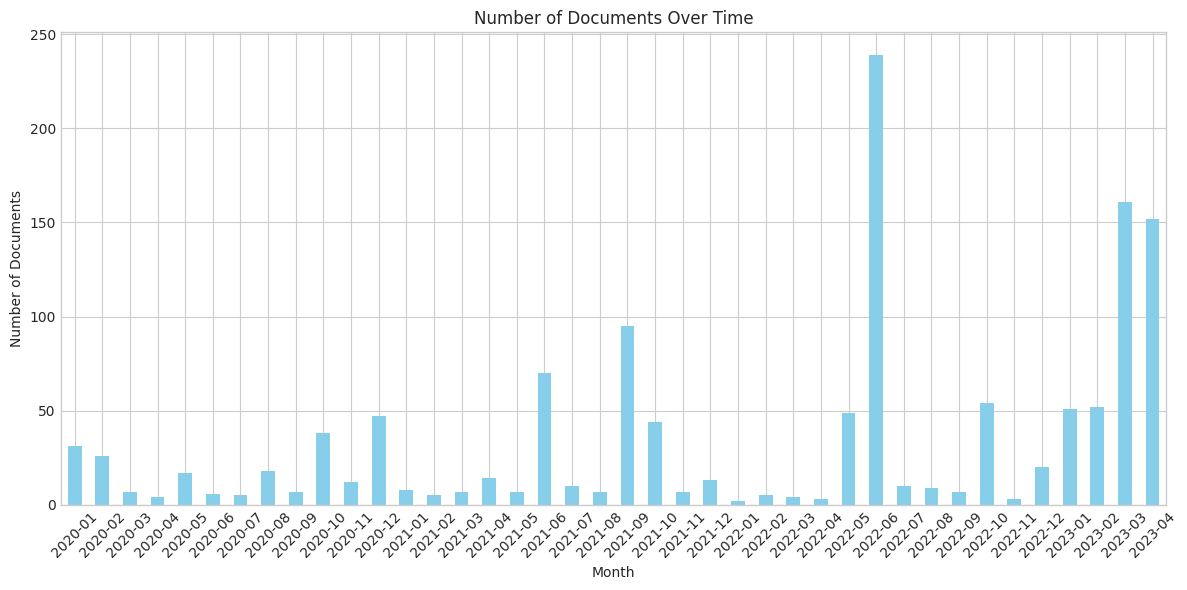

In [156]:
import matplotlib.pyplot as plt

chatgpt_filtered['date'] = pd.to_datetime(chatgpt_filtered['date'])

# Extract the month and year from the 'date' column
chatgpt_filtered['month_year'] = chatgpt_filtered['date'].dt.to_period('M')

# Group the documents by month and count the number of documents in each month
documents_by_month = chatgpt_filtered.groupby('month_year').size()

# Create the bar graph
plt.figure(figsize=(12, 6))  # Set the figure size
documents_by_month.plot(kind='bar', color='skyblue')  # Create the bar plot
plt.title('Number of Documents Over Time')  # Add a title to the plot
plt.xlabel('Month')  # Add a label to the x-axis
plt.ylabel('Number of Documents')  # Add a label to the y-axis
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.tight_layout()  # Adjust the spacing
plt.show()  # Show the plot

#### extract entities from this chatgpt df

In [84]:
#!pip install spacy

In [157]:
#!python -m spacy download en_core_web_sm


In [208]:
#!python -m spacy download en_core_web_trf

In [215]:
#!python -m spacy download en_core_web_lg


In [2]:
import spacy 
from spacy import displacy
from spacy.util import minibatch, compounding
from tqdm import tqdm
spacy.prefer_gpu()
#spacy.require_gpu()

print(spacy.__version__)


3.5.3


In [211]:
#!pip install spacy-transformers

In [7]:
# nlp = spacy.load("en_core_web_sm",exclude=['tok2vec','lemmatizer'])
nlp = spacy.load("en_core_web_lg",exclude=['tok2vec','lemmatizer'])


In [216]:
df_analysis_sample = chatgpt_filtered

In [217]:
%%time
# spacy run on content_clean (not lower cased text)
#run on 1326 for now (could run it on the unfiltered with all probabilities of documents for the topic)
# Define the entity labels of interest
entity_labels = ['ORG', 'PRODUCT', 'PERSON', 'NORP']

# Function to extract top entities by label and year
def extract_top_entities_by_label_and_year(documents, label):
    entities_by_year = {}
    for doc, year in zip(nlp.pipe(documents), df_analysis_sample['date'].dt.year):
        if year not in entities_by_year:
            entities_by_year[year] = []
        entities_by_year[year].extend([ent.text for ent in doc.ents if ent.label_ == label])
    return entities_by_year

# Dictionary to store top entities DataFrames by label
df_entities_by_label = {}

# Iterate over each entity label
for label in entity_labels:
    top_entities_by_label_and_year = extract_top_entities_by_label_and_year(df_analysis_sample['content_clean'], label)
    max_length = max(len(entities) for entities in top_entities_by_label_and_year.values())
    padded_entities_by_year = {year: entities + [''] * (max_length - len(entities))
                               for year, entities in top_entities_by_label_and_year.items()}
    df_entities_by_label[label] = pd.DataFrame(padded_entities_by_year)

# Example: Accessing the top entities for 'ORG'
top_org_entities = df_entities_by_label['ORG']
# print(top_org_entiies)


CPU times: user 8min 18s, sys: 1min 27s, total: 9min 46s
Wall time: 9min 46s


In [220]:
top_org_entities.head(5)
#using large spacy

2023                          2020  \
0       Live Search Search CTV             the White House's   
1    TORONTO Search Search CTV                            AI   
2                Noon CTV News   Facebook Follow VentureBeat   
3                 Six CTV News    Twitter Follow VentureBeat   
4  Guelph Kitchener Lethbridge  Instagram Follow VentureBeat   

                            2021                                    2022  
0                           U.N.                             White House  
1       The Washington Post Skip          EHealth Tips TuesdayUS & World  
2             PostDemocracy Dies                       Critter CornerSki  
3                   DarknessSign  Meteorologist VisitWeather CamsGetting  
4  Washington PostDemocracy Dies                       BureauInvestigate

In [196]:
top_org_entities.head(5)
#using small spacy

2023  \
0                              AI   
1                   CTV News Skip   
2  Live Search Search CTV Toronto   
3                   Noon CTV News   
4                    Six CTV News   

                                                                                            2020  \
0                                                                              the White House's   
1  VentureBeat VentureBeat Homepage Channels GamesBeat AI AR/VR Big Data Business Cloud Commerce   
2                                                                    Facebook Follow VentureBeat   
3                                                                    LinkedIn Follow VentureBeat   
4                                                                   Flipboard Follow VentureBeat   

                                                   2021  \
0                                                  U.N.   
1                              The Washington Post Skip   
2                         Washington PostDemocracy Dies   
3                                                   NaN   
4  DarknessWorldAfrica Americas Asia Europe Middle East   

                                                  2022  
0                                          White House  
1                           AnswersConsumer NewsSchool  
2                                         TrackerJanna  
3                      Critter CornerSki ReportRequest  
4  Night FrenzyArea Gas PricesLocal InformationContact

In [195]:
# Assuming 'top_person_entities' is your DataFrame with columns '2020', '2021', '2022', '2023'

# Iterate over each column in the DataFrame
for column in top_org_entities.columns:
    # Remove duplicates and keep only the first occurrence within each column
    top_org_entities[column] = top_org_entities[column].drop_duplicates(keep='first')


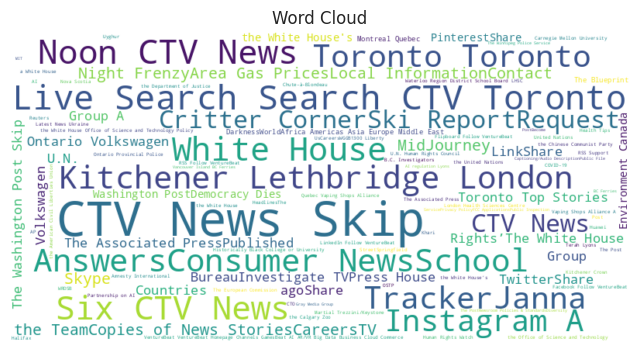

In [197]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get the top 50 rows from the DataFrame
top_rows = top_org_entities.head(50)

# Create a dictionary to store the word frequencies and weights
word_frequencies = {}
word_weights = {}

# Iterate over each column in the DataFrame
for column in top_org_entities.columns:
    # Get the values and weights for the current column
    values = top_rows[column].dropna().values
    weights = range(len(values), 0, -1)  # Assign higher weights to lower rows
    
    # Combine the values and weights into a dictionary
    word_frequencies.update(dict(zip(values, weights)))
    
# Create a WordCloud object
wordcloud = WordCloud(background_color='white', width=800, height=400, colormap='viridis')

# Generate the word cloud from the weighted frequencies
wordcloud.generate_from_frequencies(word_frequencies)

# Plot the word cloud
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud')
plt.axis('off')
plt.show()


In [186]:
top_person_entities = df_entities_by_label['PERSON']


In [221]:
top_person_entities_large = df_entities_by_label['PERSON']


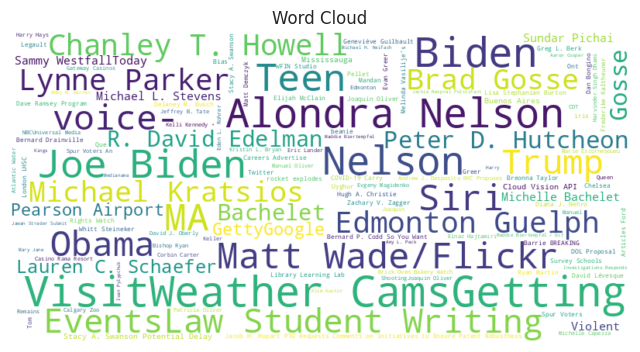

In [190]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get the top 50 rows from the DataFrame
top_rows = top_person_entities.head(50)

# Create a dictionary to store the word frequencies and weights
word_frequencies = {}
word_weights = {}

# Iterate over each column in the DataFrame
for column in top_person_entities.columns:
    # Get the values and weights for the current column
    values = top_rows[column].dropna().values
    weights = range(len(values), 0, -1)  # Assign higher weights to lower rows
    
    # Combine the values and weights into a dictionary
    word_frequencies.update(dict(zip(values, weights)))
    
# Create a WordCloud object
wordcloud = WordCloud(background_color='white', width=800, height=400, colormap='viridis')

# Generate the word cloud from the weighted frequencies
wordcloud.generate_from_frequencies(word_frequencies)

# Plot the word cloud
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud')
plt.axis('off')
plt.show()


In [184]:
# Assuming 'top_person_entities' is your DataFrame with columns '2020', '2021', '2022', '2023'

# Iterate over each column in the DataFrame
for column in top_person_entities.columns:
    # Remove duplicates and keep only the first occurrence within each column
    top_person_entities[column] = top_person_entities[column].drop_duplicates(keep='first')


In [223]:
top_product_entities = df_entities_by_label['PRODUCT']


In [225]:
# Assuming 'top_person_entities' is your DataFrame with columns '2020', '2021', '2022', '2023'

# Iterate over each column in the DataFrame
for column in top_product_entities.columns:
    # Remove duplicates and keep only the first occurrence within each column
    top_product_entities[column] = top_product_entities[column].drop_duplicates(keep='first')


In [174]:
top_product_entities.head(10)
#small spacy

2023                         2020  \
0                   Winnipeg One   Twitter Follow VentureBeat   
1                      Subscribe   Twitter Follow VentureBeat   
2              Rs 300 to 217,400                google google   
3                        Twitter                      Twitter   
4  K-12 Private EducationLincoln                     Prepared   
5                           K-12                          375   
6                        Drivers  F Full Weather Sponsored By   
7                      Subscribe                 NewsParkland   
8                        Twitter                      Twitter   
9                        Twitter                       Follow   

                                    2021  \
0                                  Cache   
1                           OnePlus Band   
2                          PlayStation 5   
3                          PlayStation 5   
4                           OnePlus Band   
5                                Twitter   
6                    Subscribe Now X You   
7                    9/15/21 Read Next 4   
8                            Tech Xplore   
9  Newsletters Subscribe Science X Daily   

                                     2022  
0                     Number 286 Login FB  
1                                   Solar  
2                          ServicePrivacy  
3     77e1f0fccd RUSSIA-UKRAINE WAR: Live  
4  The Third Battle of Manassas: Historic  
5                     Subscribe Subscribe  
6                             BusinessFun  
7                              VideosTake  
8                          ServicePrivacy  
9                                   Share

In [193]:
top_norp_entities = df_entities_by_label['NORP']


In [194]:
top_norp_entities

2023            2020       2021        2022
0               Reddit         Edelman   European    American
1               Reddit       Europeans  ServiceAd      Indian
2             Canadian        European      Asian  Collateral
3            Canadians  Uighur Muslims   European    American
4            Ukrainian         Chinese    Western     Russian
...                ...             ...        ...         ...
1123              Arya                                       
1124  HoganNew Yorkers                                       
1125          OffsMost                                       
1126             Avian                                       
1127          American                                       

[1128 rows x 4 columns]

#### topic search - topic 7 - Elon Musk

In [203]:
#which topics interest me?
#topic 2 (chatgpt/students), topic 3 (china), topic 4 (health / medical), topic 5 (cybersecurity), 
#topic 6 (clearview, haeleon, human intelligence)
#topic 7 (elon musk ai) 
#topic 9 (ford driving automotive ai)
#topic 10 (eu rules ai)
#topic 14 (soundhound whisper ai)
#topic 16 (climate change)
#topic 18 (airlines)
#topic 20 (insurance)
#topic 23 (patent inventor drug law)
#topic 27 (agriculture ai)
#topic 40 (biometrics)
#topic 41 (oil gas)
#topic 43 bill gates
#topic 46 iot intelligence
#topic 25 (shipping vessels - forced labor)

In [204]:
topic_model.get_topic(7)
#Musk

[('musk', 0.02573649391349288),
 ('elon', 0.0134040512576289),
 ('elon musk', 0.012704228755071207),
 ('ai', 0.009853280837789283),
 ('openai', 0.008939002985551463),
 ('tesla', 0.008835822618572166),
 ('news', 0.007703908803972084),
 ('letter', 0.007393194494888328),
 ('tire', 0.006570655625396093),
 ('lisk machine', 0.006139779272358006)]

In [206]:
selected_topics = [7]
elon_df = df_topics_negative[df_topics_negative['Topic'].isin(selected_topics)]


In [228]:
elon_df.shape

(669, 11)

In [230]:
elon_df = elon_df[elon_df['Probability'] > 0.99]

# Count the number of rows satisfying the condition
count = elon_df.shape[0]
count

#1326 topics chosen from 3209 to plot as most representative according to probability method of Bertopics

574

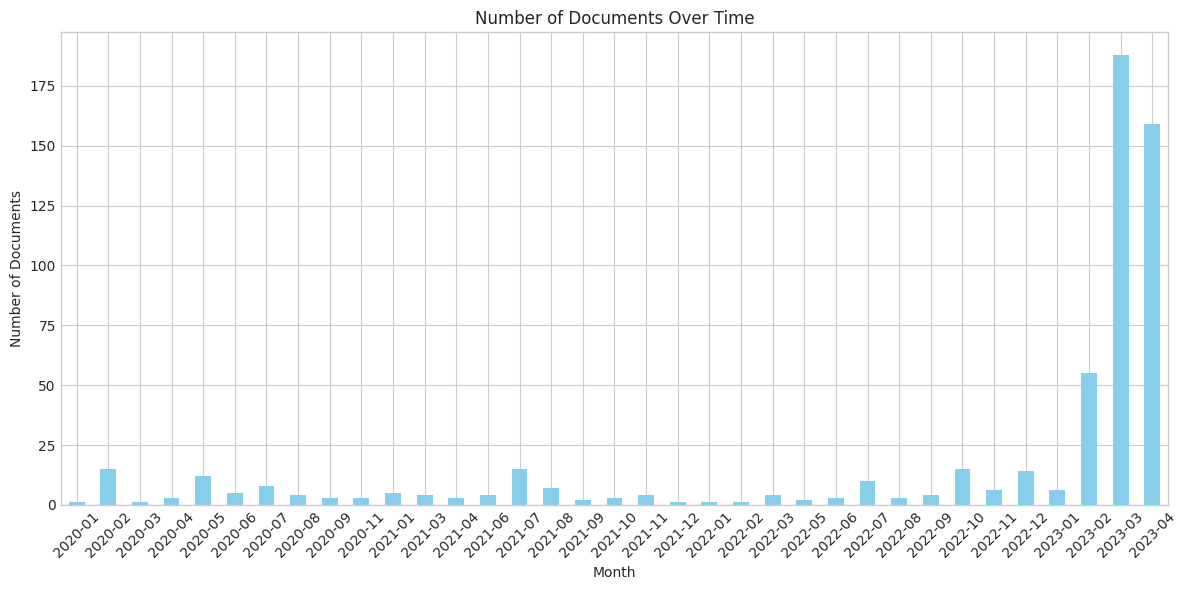

In [231]:
import matplotlib.pyplot as plt

elon_df['date'] = pd.to_datetime(elon_df['date'])

# Extract the month and year from the 'date' column
elon_df['month_year'] = elon_df['date'].dt.to_period('M')

# Group the documents by month and count the number of documents in each month
documents_by_month = elon_df.groupby('month_year').size()

# Create the bar graph
plt.figure(figsize=(12, 6))  # Set the figure size
documents_by_month.plot(kind='bar', color='skyblue')  # Create the bar plot
plt.title('Number of Documents Over Time')  # Add a title to the plot
plt.xlabel('Month')  # Add a label to the x-axis
plt.ylabel('Number of Documents')  # Add a label to the y-axis
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.tight_layout()  # Adjust the spacing
plt.show()  # Show the plot

In [232]:
df_analysis_sample = elon_df

In [233]:
%%time
# spacy run on content_clean (not lower cased text)
#run on 1326 for now (could run it on the unfiltered with all probabilities of documents for the topic)
# Define the entity labels of interest
entity_labels = ['ORG', 'PRODUCT', 'PERSON']

# Function to extract top entities by label and year
def extract_top_entities_by_label_and_year(documents, label):
    entities_by_year = {}
    for doc, year in zip(nlp.pipe(documents), df_analysis_sample['date'].dt.year):
        if year not in entities_by_year:
            entities_by_year[year] = []
        entities_by_year[year].extend([ent.text for ent in doc.ents if ent.label_ == label])
    return entities_by_year

# Dictionary to store top entities DataFrames by label
df_entities_by_label = {}

# Iterate over each entity label
for label in entity_labels:
    top_entities_by_label_and_year = extract_top_entities_by_label_and_year(df_analysis_sample['content_clean'], label)
    max_length = max(len(entities) for entities in top_entities_by_label_and_year.values())
    padded_entities_by_year = {year: entities + [''] * (max_length - len(entities))
                               for year, entities in top_entities_by_label_and_year.items()}
    df_entities_by_label[label] = pd.DataFrame(padded_entities_by_year)

# Example: Accessing the top entities for 'ORG'
top_org_entities_elon = df_entities_by_label['ORG']
# print(top_org_entiies)


CPU times: user 2min 17s, sys: 21.9 s, total: 2min 39s
Wall time: 2min 38s


In [236]:
top_person_entities_elon = df_entities_by_label['PERSON']
top_product_entities_elon = df_entities_by_label['PRODUCT']


In [235]:
top_org_entities_elon.head(10)

2023  \
0                                                                                                                                                                                                                               Tesla   
1                                                                                                                                                                                                                                 EMI   
2                                                                                                                                                                                                                             HT Auto   
3  Search Log In Home Latest News News News Auto News Car News Bike News Electric Vehicle News Reviews How To Find Vehicles Find Vehicles Find Cars Find Bikes Compare Compare Compare Cars Compare Bikes OffersNEW My Garage Dealers   
4                                                                                                                                                                                                             Citing Risks To Society   
5                                                                                                                                                                                                                               Tesla   
6                                                                                                                                                                                                                             Reuters   
7                                                                                                                                                                                                                              OpenAI   
8                                                                                                                                                                                                            Future of Life Institute   
9                                                                                                                                                                                                                             Twitter   

                 2022                  2020  \
0            New Zoom      FOX News Network   
1  TechCentral Search                   LLC   
2            Facebook  AI By James Rogers |   
3   LinkedIn Facebook              Fox News   
4            Dis-Chem              Facebook   
5                 MTN                    AI   
6               Apple              Facebook   
7         Post Office                  CNBC   
8               Tesla                 Tesla   
9                  EA                SpaceX   

                                                     2021  
0  Reviews Tech Auto Games Culture Subscribe Go Tech Apps  
1                                                  OpenAI  
2                                                  Pexels  
3                                                  Toyota  
4                                                  Tundra  
5                                 Sequioa Coming Soon Too  
6                                                  Pexels  
7                               the British Theatre Guide  
8                              an Artificial Intelligence  
9                                                   GPT-2

In [237]:
top_person_entities_elon.head(5)

2023       2022            2020            2021
0      Elon Musk       Musk       Elon Musk     Elon Musk's
1  Ceo Elon Musk      Trump     Foxnews.com       Elon Musk
2      Elon Musk  Elon Musk       Elon Musk     Elon Musk's
3      Elon Musk       Musk            Musk  Markus Winkler
4          GPT-4    Twitter  Jerome Pesenti     Elon Musk's

In [241]:
top_product_entities_elon.head(5)

2023              2022    2020                   2021
0        AI   Twitter YouTube      AI             JavaScript
1        AI  Twitter LinkedIn      AI                     AI
2        AI            BigFix  SpaceX                     AI
3        AI             Cisco      AI  4Runner TRD Pro Color
4  DeepMind           BOATech      AI                     AI

#### Analysis on Elon_df - negative articles on chatgpt (look at the articles)

In [247]:
#elon_df.head(5)

#### topic search - topic 9 - Automotive

In [249]:
topic_model.get_topic(9)
#Ford / Driving / Automotive / Automonous

[('ford', 0.013866570543822102),
 ('driving', 0.01335653672093919),
 ('ai', 0.013033024667231953),
 ('cars', 0.010459531417790963),
 ('automotive', 0.009561054481019453),
 ('self driving', 0.008487544306452165),
 ('autonomous', 0.008208834846204507),
 ('vehicles', 0.007839642453602849),
 ('self', 0.007411258706136407),
 ('argo', 0.007245306012230565)]

In [11]:
selected_topics = [9]
auto_df = df_topics_negative[df_topics_negative['Topic'].isin(selected_topics)]


In [253]:
auto_df.shape

(558, 11)

In [12]:
auto_df_filtered = auto_df[auto_df['Probability'] > 0.9]

# Count the number of rows satisfying the condition
count = auto_df_filtered.shape[0]
count

#1326 topics chosen from 3209 to plot as most representative according to probability method of Bertopics

281

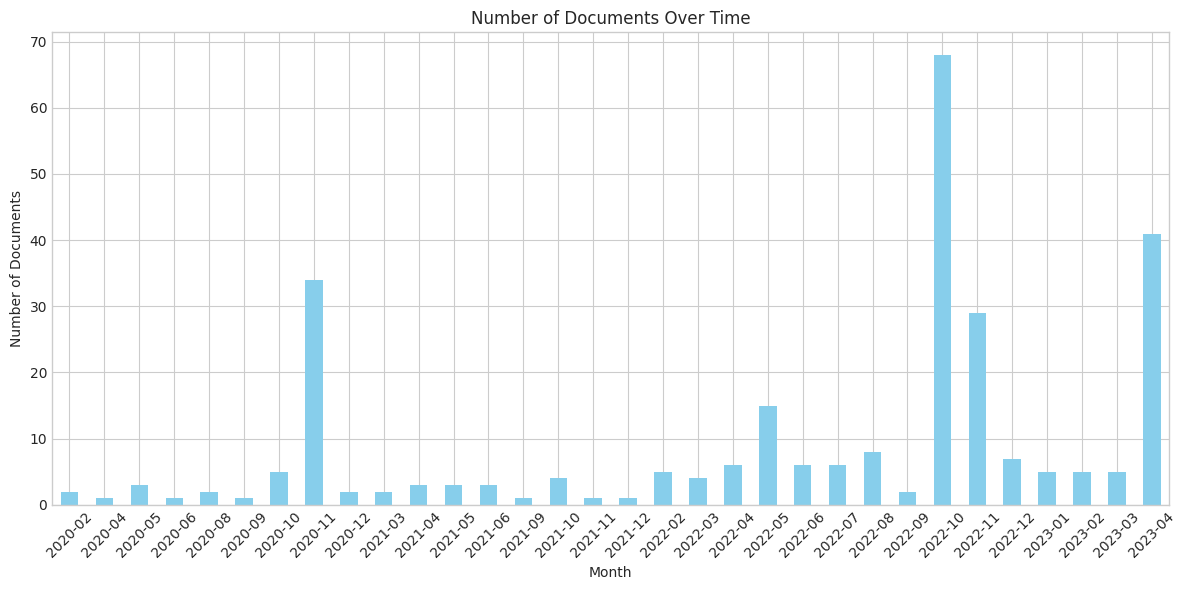

In [263]:
import matplotlib.pyplot as plt

auto_df_filtered['date'] = pd.to_datetime(auto_df_filtered['date'])

# Extract the month and year from the 'date' column
auto_df_filtered['month_year'] = auto_df_filtered['date'].dt.to_period('M')

# Group the documents by month and count the number of documents in each month
documents_by_month = auto_df_filtered.groupby('month_year').size()

# Create the bar graph
plt.figure(figsize=(12, 6))  # Set the figure size
documents_by_month.plot(kind='bar', color='skyblue')  # Create the bar plot
plt.title('Number of Documents Over Time')  # Add a title to the plot
plt.xlabel('Month')  # Add a label to the x-axis
plt.ylabel('Number of Documents')  # Add a label to the y-axis
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.tight_layout()  # Adjust the spacing
plt.show()  # Show the plot

In [264]:
df_analysis_sample = auto_df_filtered

In [265]:
%%time
# spacy run on content_clean (not lower cased text)
#run on 1326 for now (could run it on the unfiltered with all probabilities of documents for the topic)
# Define the entity labels of interest
entity_labels = ['ORG', 'PRODUCT', 'PERSON']

# Function to extract top entities by label and year
def extract_top_entities_by_label_and_year(documents, label):
    entities_by_year = {}
    for doc, year in zip(nlp.pipe(documents), df_analysis_sample['date'].dt.year):
        if year not in entities_by_year:
            entities_by_year[year] = []
        entities_by_year[year].extend([ent.text for ent in doc.ents if ent.label_ == label])
    return entities_by_year

# Dictionary to store top entities DataFrames by label
df_entities_by_label = {}

# Iterate over each entity label
for label in entity_labels:
    top_entities_by_label_and_year = extract_top_entities_by_label_and_year(df_analysis_sample['content_clean'], label)
    max_length = max(len(entities) for entities in top_entities_by_label_and_year.values())
    padded_entities_by_year = {year: entities + [''] * (max_length - len(entities))
                               for year, entities in top_entities_by_label_and_year.items()}
    df_entities_by_label[label] = pd.DataFrame(padded_entities_by_year)


CPU times: user 1min 36s, sys: 16.3 s, total: 1min 52s
Wall time: 1min 52s


In [273]:
%%time
# spacy run on content_clean (not lower cased text)
#run on 1326 for now (could run it on the unfiltered with all probabilities of documents for the topic)
# Define the entity labels of interest
entity_labels = ['ORG', 'PRODUCT', 'PERSON']

# Function to extract top entities by label and year
def extract_top_entities_by_label_and_year(documents, label):
    entities_by_year = {}
    for doc, year in zip(nlp.pipe(documents), df_analysis_sample['date'].dt.year):
        if year not in entities_by_year:
            entities_by_year[year] = []
        entities_by_year[year].extend([ent.text for ent in doc.ents if ent.label_ == label])
    return entities_by_year

# Dictionary to store top entities DataFrames by label
df_entities_by_label = {}

# Iterate over each entity label
for label in entity_labels:
    top_entities_by_label_and_year = extract_top_entities_by_label_and_year(df_analysis_sample['title'], label)
    max_length = max(len(entities) for entities in top_entities_by_label_and_year.values())
    padded_entities_by_year = {year: entities + [''] * (max_length - len(entities))
                               for year, entities in top_entities_by_label_and_year.items()}
    df_entities_by_label[label] = pd.DataFrame(padded_entities_by_year)


CPU times: user 811 ms, sys: 194 µs, total: 811 ms
Wall time: 808 ms


In [274]:
# Example: Accessing the top entities for 'ORG'
top_org_entities_auto_title = df_entities_by_label['ORG']
top_person_entities_auto_title = df_entities_by_label['PERSON']
top_product_entities_auto_title = df_entities_by_label['PRODUCT']


In [279]:
top_product_entities_auto_title.head(5)

2022                    2023  2021                       2020
0  Cariad                      AI  ADAS                         AI
1      AI                      AI    AI  Kuga Intelligent AWD Uses
2      AI                      X5    AI                         AI
3      AI  AI Car Diagnosis - Get    AI                         AI
4      AI                    T-80

In [267]:
top_org_entities_auto.head(5)

2022                                     2023  \
0                         Volkswagen                                       AI   
1                          Auto News                                VergeSkip   
2                       Power Dealer  The Verge homepageThe Verge homepageThe   
3                             ETAuto                                       AI   
4  Autolytics View Site Volkswagen's                                       AI   

                                                                                                                   2021  \
0  UN Top Sections Auto News Car News Bike News Latest Auto News Photos Videos Electric Vehicles Trending My Reads Find   
1                                                                                                                   EMI   
2                                                                                                                    UN   
3                                                                                                                    UN   
4                                                                             the International Telecommunication Union   

                              2020  
0                BillionairesWorld  
1                           Forbes  
2  Richest Self-Made Women China's  
3         Richest Money & Politics  
4                    InnovationAll

In [271]:
top_person_entities_auto.head(5)

2022                2023            2021         2020
0  Paragon Semvox  Michael Schumacher   Ampere Magnus       Forbes
1  paragon semvox  Michael Schumacher  Atumobile Atum       Forbes
2   Kaleva Norman  Michael Schumacher     Houlin Zhao       Nuveen
3   Mark Humphrey     Jess Weatherbed       Jean Todt         Gado
4   Mark Humphrey   UTC|CommentsShare    AreaExpandIn  Andrew Pole

In [269]:
top_product_entities_auto.head(5)

2022  \
0                                                                                                                           Cariad   
1                                                                                                                               AI   
2  IndustrySpeak IndustrySpeak Interviews Autologue ETAuto Insights Dealers Data & Analytics Data & Analytics ETAutolytics Reports   
3                                                                        ETAuto Natural Gas Vehicle Conclave E-Mobility Convention   
4                                                                                            EnvironRise ET Auto EnvironRiseAwards   

         2023                                      2021      2020  
0          AI                                 FASTagnew        AI  
1          AI                            Toutche Heileo        AI  
2          AI                        NoticesJobsVoucher        AI  
3         Air                            UsAbout UsWork        AI  
4  Cybertruck  UsCompetition RulesTerms & ConditionsHow  MoreArun

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")

model = AutoModelForSequenceClassification.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")


In [ ]:
# Function to encode text and return the predicted sentiment
def get_sentiment(text):
    encoded_input = tokenizer(text, return_tensors='pt')  # Encode the input text
    output = model(**encoded_input)  # Pass the encoded text to the model
    logits = output.logits  # Get the model output logits
    probs = torch.nn.functional.softmax(logits, dim=-1)  # Convert logits to probabilities
    sentiment = torch.argmax(probs).item()  # Get the sentiment with the maximum probability
    return sentiment

# List of keywords related to 'automation'
keywords = ['automation', 'automate', 'automated']

# Filter out sentences which contain keywords related to 'automation'
auto_df_filtered['contains_keyword'] = auto_df_filtered['content_clean'].apply(lambda x: any(keyword in x for keyword in keywords))

# Only perform sentiment analysis on sentences related to 'automation'
auto_df_filtered['sentiment'] = auto_df_filtered[auto_df_filtered['contains_keyword']]['content_clean'].apply(get_sentiment)


/var/tmp/ipykernel_335015/503322214.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auto_df_filtered['contains_keyword'] = auto_df_filtered['content_clean'].apply(lambda x: any(keyword in x for keyword in keywords))
